# Boston Housing Prices: Project 1 

In [1]:
%matplotlib inline

In [2]:
"""Load the Boston dataset and examine its target (label) distribution."""
# Load libraries
import os
import numpy as np
import pylab as pl
import matplotlib.pyplot as pl

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.set_context('notebook')
import pandas as pd

Load Data

In [3]:
def load_data():
    """Load the Boston dataset."""
    boston = datasets.load_boston()
    #print boston.keys()
    #print boston.DESCR
    return boston

DataFrame

In [4]:
boston = load_data()

def dataframe(city_data):
    housing_prices = city_data.target
    housing_features = city_data.data
    X,y = housing_features, housing_prices
    df_data = pd.DataFrame(housing_features, columns = boston.feature_names)
    df_target = pd.DataFrame(housing_prices, columns =['MEDV'])
    df_boston = pd.concat([df_data, df_target,], axis = 1)
    df = df_boston.corr()
    corr_target = df.ix[-1][:-1]
    predict = corr_target.sort(ascending=False)
    df_sort = corr_target.sort_values(ascending=False)
    print(df_sort)
    print(df)
    return df_boston


Statistics

In [5]:
def histogram(city_data):
    housing_prices = city_data.target
    housing_features = city_data.data
    X,y = housing_features, housing_prices
    pl.hist(y, bins =20, color = 'green')
    pl.suptitle('Boston Housing Prices', fontsize = 24)
    pl.xlabel('Housing Prices [$10k]', fontsize = 16)
    pl.ylabel('Frequency', fontsize = 16)
    pl.show()
    
def scatter_plots(city_data):
    pl.figure()
    fig,axes = pl.subplots(4, 4, figsize=(14,18))
    fig.subplots_adjust(wspace=.4, hspace=.4)
    img_index = 0
    for i in range(boston.feature_names.size):
        row, col = i // 4, i % 4
        axes[row][col].scatter(boston.data[:,i],boston.target)
        axes[row][col].set_title(boston.feature_names[i] + ' and MEDV')
        axes[row][col].set_xlabel(boston.feature_names[i])
        axes[row][col].set_ylabel('MEDV')
    filepath = '/Users/tracesmith/Desktop/Udacity/class/machine_learning/Project_1/images'
    filename = ("MEDV vs Features")
    filename = os.path.join(filepath, filename)
    pl.savefig(filename)
    
def explore_city_data(city_data):
    """Calculate the Boston housing statistics."""

    # Get the labels and features from the housing data
    housing_prices = city_data.target
    housing_features = city_data.data

    # Size of data (number of houses)?
    number_houses = housing_features.shape[0]
    print "Number of houses:", number_houses
   
    # Number of features?
    number_features = housing_features.shape[1]
    print "Number of features:", number_features
   
    # Minimum price?
    min_price = np.min(housing_prices)
    print "Minimum Housing Price: ${:,.2f}".format(min_price)

    # Maximum price?
    
    max_price = np.max(housing_prices)
    print "Maximum Housing Price: ${:,.2f}".format(max_price)

    # Calculate mean price?
    
    mean_price = np.mean(housing_prices)
    print "Mean Housing Price: ${:,.2f}".format(mean_price)

    # Calculate median price?
    
    median_price = np.median(housing_prices)
    print "Median Housing Price: ${:,.2f}".format(median_price)

    # Calculate standard deviation?
    
    std_price = np.std(housing_prices)
    print "Standard Deviation: ${:,.2f}".format(std_price) 


Split Data

In [6]:
def split_data(city_data):
    """Randomly shuffle the sample set. Divide it into 70 percent training 
    and 30 percent testing data."""

    # Get the features and labels from the Boston housing data
    X, y = city_data.data, city_data.target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                        random_state=None)

    #print "X_training:", X_train.shape
    #print "X_test:", X_test.shape 
    
    return X_train, y_train, X_test, y_test

Performance Metric

In [7]:
def performance_metric(label, prediction):
    """Calculate and return the appropriate error performance metric."""
    
    # The following page has a table of scoring functions in sklearn:
    # http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics
    #mae = mean_absolute_error(label, prediction)
    mse = mean_squared_error(label, prediction)
    return mse
    pass

Learning Curve

In [8]:
def learning_curve(depth, X_train, y_train, X_test, y_test):
    """Calculate the performance of the model after a set of training data."""

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.round(np.linspace(1, len(X_train), 50))
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    print "Decision Tree with Max Depth: "
    print (depth)

    for i, s in enumerate(sizes):

        # Create and fit the decision tree regressor model
        regressor = DecisionTreeRegressor(max_depth=depth)
        regressor.fit(X_train[:s], y_train[:s])

        # Find the performance on the training and testing set
        train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))


    # Plot learning curve graph
    learning_curve_graph(sizes, train_err, test_err)


def learning_curve_graph(sizes, train_err, test_err):
    """Plot training and test error as a function of the training size."""
    pl.figure()
    pl.title('Decision Trees: Performance vs Training Size', fontsize = 20)
    pl.plot(sizes, test_err, lw=2, label = 'test error')
    pl.plot(sizes, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Training Size', fontsize = 14)
    pl.ylabel('Error', fontsize =14)
    pl.show()

Model Complexity

In [9]:
def model_complexity(X_train, y_train, X_test, y_test):
    """Calculate the performance of the model as model complexity increases."""

    print "Model Complexity: "

    # We will vary the depth of decision trees from 2 to 25
    max_depth = np.arange(1, 25)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        # Setup a Decision Tree Regressor so that it learns a tree with depth d
        regressor = DecisionTreeRegressor(max_depth=d)

        # Fit the learner to the training data
        regressor.fit(X_train, y_train)

        # Find the performance on the training set
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))

        # Find the performance on the testing set
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity graph
    model_complexity_graph(max_depth, train_err, test_err)


def model_complexity_graph(max_depth, train_err, test_err):
    """Plot training and test error as a function of the depth of the decision tree learn."""
    pl.figure()
    pl.title('Decision Trees: Performance vs Max Depth', fontsize = 20)
    pl.plot(max_depth, test_err, lw=2, label = 'test error')
    pl.plot(max_depth, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Max Depth',fontsize =14)
    pl.ylabel('Error', fontsize =14)
    pl.show()

Fit Model

In [10]:
def fit_predict_model(city_data):
    """Find and tune the optimal model. Make a prediction on housing data."""

    # Get the features and labels from the Boston housing data
    
    X, y = city_data.data, city_data.target

    # Setup a Decision Tree Regressor
    
    regressor = DecisionTreeRegressor()
    
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    
    mse_scoring = make_scorer(mean_squared_error, greater_is_better=False)
    
    #use grid search to fine tune the Decision Tree Regressor and
    #obtain the parameters that generate the best training performance. 

    reg = GridSearchCV(regressor, parameters, scoring = mse_scoring)
    reg.fit(X,y)
    
    # Fit the learner to the training data to obtain the best parameter set
    print "Final Model: "
    print (reg.fit(X, y))    

    # Use the model to predict the output of a particular sample
    x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    x = np.array(x)
    x = x.reshape(1, -1)
    y = reg.predict(x)
    
    print "Best Parameters: ", reg.best_params_
    print "Best Estimator:", reg.best_estimator_
    print "Grid Score:", reg.grid_scores_

    print "House: " + str(x)
    print "Predicted: " + str(y)
    
    #DataFrame of Client_Features
    #x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    #pd.DataFrame(zip(boston.feature_names, x), columns = ['Features', 'Client_Features'])
    

Main

/Users/tracesmith/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/Users/tracesmith/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/tracesmith/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.385832
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64
             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.199458  0.404471 -0.055295  0.417521 -0.219940  0.350784   
ZN      -0.199458  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.404471 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055295 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.417521 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219940  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.350784 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.377904  0.664408 -0.708027 -0.099176 -0.769230  0.2052

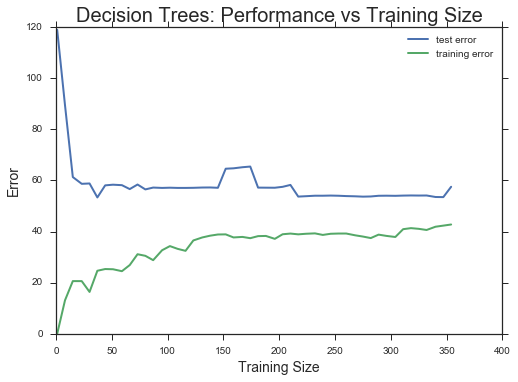

Decision Tree with Max Depth: 
2


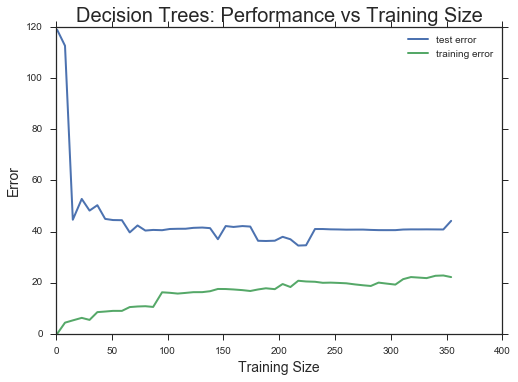

Decision Tree with Max Depth: 
3


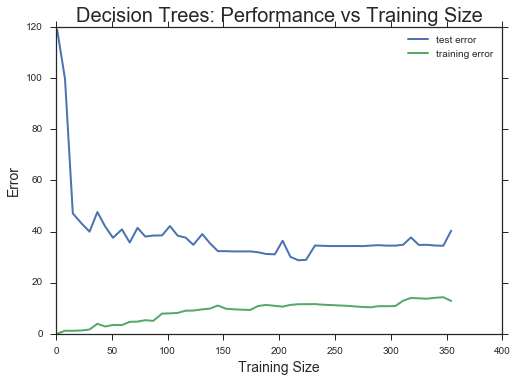

Decision Tree with Max Depth: 
4


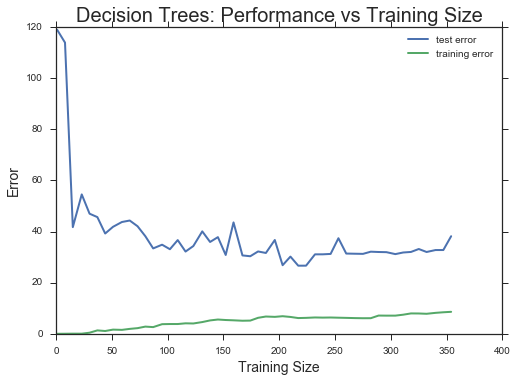

Decision Tree with Max Depth: 
5


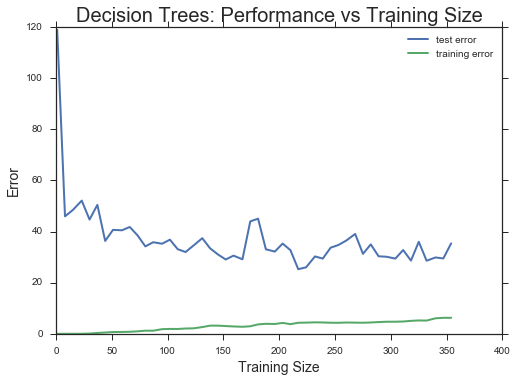

Decision Tree with Max Depth: 
6


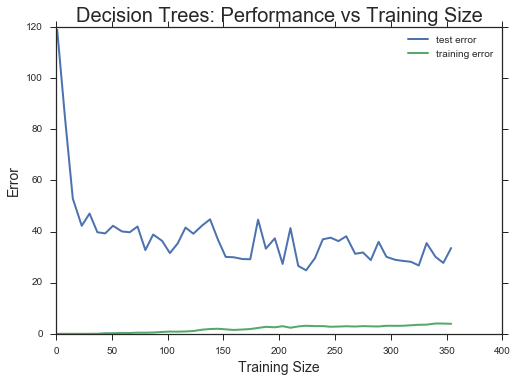

Decision Tree with Max Depth: 
7


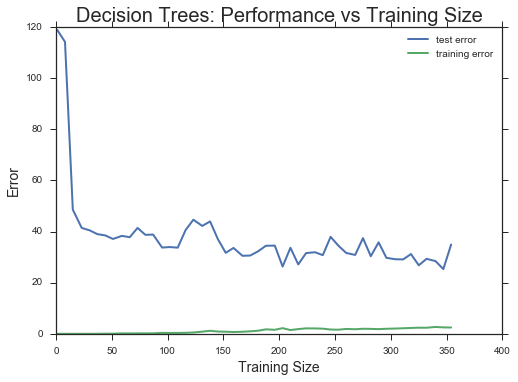

Decision Tree with Max Depth: 
8


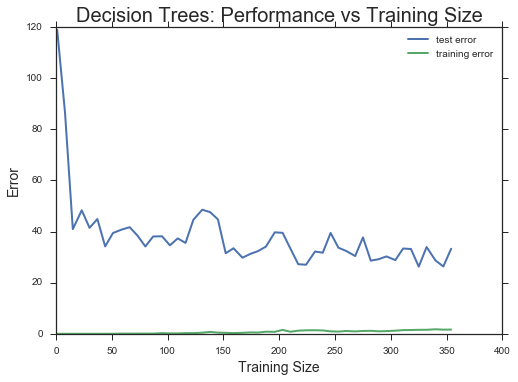

Decision Tree with Max Depth: 
9


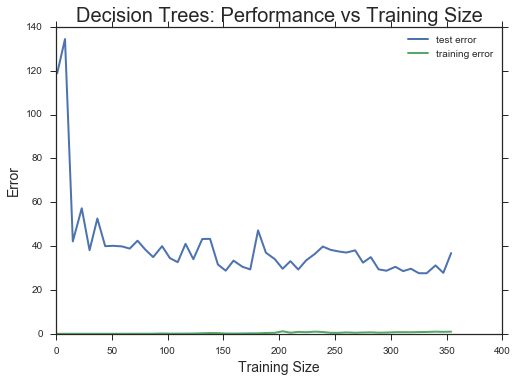

Decision Tree with Max Depth: 
10


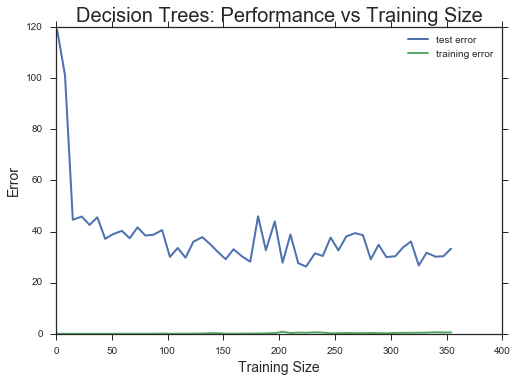

Model Complexity: 


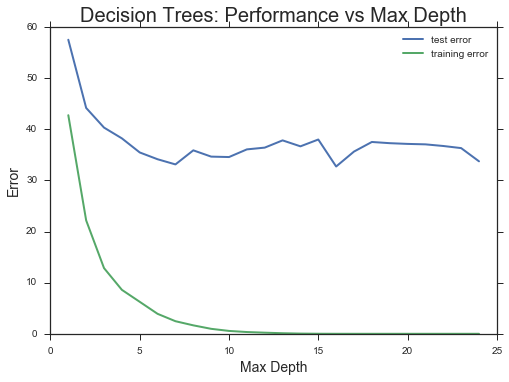

Final Model: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)
Best Parameters:  {'max_depth': 5}
Best Estimator: DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Grid Score: [mean: -68.08279, std: 25.52601, params: {'max_depth': 1}, mean: -46.72022, std: 21.02827, params: {'max_depth': 2}, mean:

In [11]:
def main():
    """Analyze the Boston housing data. Evaluate and validate the
    performanance of a Decision Tree regressor on the housing data.
    Fine tune the model to make prediction on unseen data."""

    # Load data
    city_data = load_data()
    
    #DataFrame
    dataframe(city_data)
    
    # Explore the data
    explore_city_data(city_data)

    # Training/Test dataset split
    X_train, y_train, X_test, y_test = split_data(city_data)

    # Learning Curve Graphs
    max_depths = [1,2,3,4,5,6,7,8,9,10]
    for max_depth in max_depths:
        learning_curve(max_depth, X_train, y_train, X_test, y_test)
    
    # Model Complexity Graph
    model_complexity(X_train, y_train, X_test, y_test)

    #Tune and predict Model
    fit_predict_model(city_data)


if __name__ == "__main__":
    main()

In [12]:
def iterate_fit_predict(city_data):
    """Find and tune the optimal model. Make a prediction on housing data."""

    # Get the features and labels from the Boston housing data
    X, y = city_data.data, city_data.target

    # Setup a Decision Tree Regressor
    regressor = DecisionTreeRegressor()
  
    mse_scoring = make_scorer(mean_squared_error, greater_is_better=False)
    
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    
    reg = GridSearchCV(regressor, parameters, scoring = mse_scoring, cv=3)

    # Fit the learner to the training data to obtain the best parameter set
    reg.fit(X, y)

    # Use the model to predict the output of a particular sample
    x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    x = np.array(x)
    x = x.reshape(1, -1)
    y = reg.predict(x)
    
    return (reg.best_params_['max_depth'], y[0])

Iteration: Fit and Predict Model
    (GridSearchCV Results)

In [14]:
Grid_Search_Results = []

for i in range(1000):
    Grid_Search_Results.append(iterate_fit_predict(city_data))

Grid_Search= np.asarray(Grid_Search_Results)
Grid_Search_Results_Depth = np.asarray(Grid_Search.T[0], dtype=int)
Grid_Search_Results_Price = np.asarray(Grid_Search.T[1], dtype=float)

Histogram: Maximum Depth (iterations = 10000)

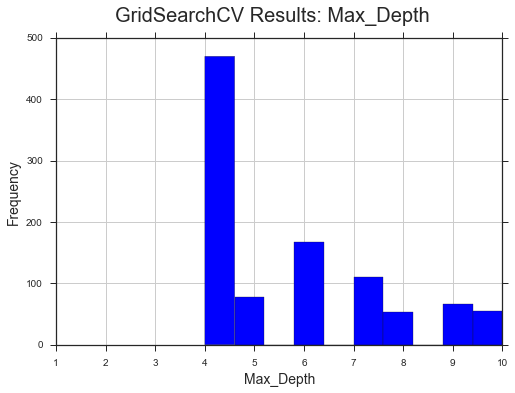

In [16]:
pl.hist(Grid_Search_Results_Depth, bins = 10, color = 'blue')
pl.suptitle("GridSearchCV Results: Max_Depth", fontsize = 20)
pl.xlabel("Max_Depth", fontsize = 14)
pl.ylabel("Frequency", fontsize = 14)
pl.xlim(1,10)
pl.grid()
pl.show()

Histogram: Predicted Housing Prices (iteraitons = 1000)

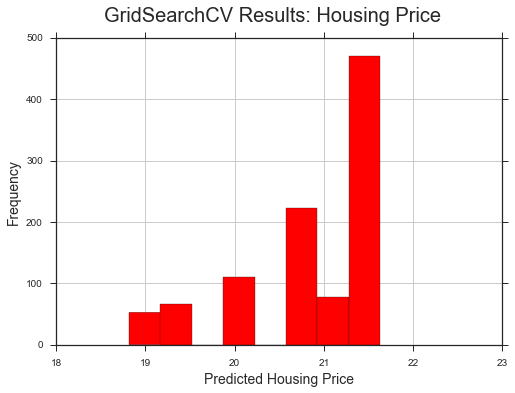

In [17]:
pl.hist(Grid_Search_Results_Price, bins = 8, color = 'red')
pl.suptitle("GridSearchCV Results: Housing Price", fontsize = 20)
pl.xlabel("Predicted Housing Price", fontsize = 14)
pl.ylabel("Frequency", fontsize = 14)
pl.xlim(18, 23.0)
pl.ylim(0, 500)
pl.grid()
pl.show()